# Transfer Learning

In this notebook, we will go through basics of Transfer Learning.

Here we will use [fastai](https://github.com/fastai/fastai/  "fastai's Tutorial").

Hey yo, but what is Transfer Learning? 

Everything is explained in-detail in [blog post](dudeperf3ct.github.io). This is notebook which replicates the result of blog and runs in colab. Enjoy!


#### Run in Colab

You can run this notebook in google colab.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

### Install Dependecies

In [0]:
!pip install --upgrade torch torchvision fastai numpy

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.0.0)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.2.1)
Requirement already up-to-date: fastai in /usr/local/lib/python3.6/dist-packages (1.0.38)
Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.15.4)


# Preprocessing data directory

## Getting Data

The cats vs dogs dataset isn't available on keras library. You can download it from Kaggle however. Let's see how to do this by using the Kaggle API as it's going to be pretty useful to you if you want to join a competition or use other Kaggle datasets later on.

First, install the Kaggle API by uncommenting the following line and executing it, or by executing it in your terminal.

In [0]:
import shutil 
shutil.rmtree('data/catsvsdogs')

In [0]:
!pip install --upgrade kaggle

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.1.1)


Then you need to upload your credentials from Kaggle on your instance. Login to kaggle and click on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Upload this file to the directory this notebook is running in, by clicking "Upload" on your main Jupyter page, then uncomment and execute the next two commands (or run them in a terminal).


In [0]:
##uncomment this to upload kaggle.json

# from google.colab import files
# def getLocalFiles():
#     _files = files.upload()
#     if len(_files) >0:
#        for k,v in _files.items():
#          open(k,'wb').write(v)
# getLocalFiles()

In [0]:
## uncomment and run this when you upload the kaggle.json

# ! mkdir -p ~/.kaggle/
# ! mv kaggle.json ~/.kaggle/

You're all set to download the data from [Dogs vs. Cats Redux: Kernels Edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data) competition. You first need to go to its main page and accept its rules, and run the two cells below (uncomment the shell commands to download and unzip the data). If you get a 403 forbidden error it means you haven't accepted the competition rules yet (you have to go to the competition page, click on Rules tab, and then scroll to the bottom to find the accept button).


In [0]:
! kaggle competitions download -c dogs-vs-cats-redux-kernels-edition -p 'data/catsvsdogs'

100% 271M/271M [00:01<00:00, 173MB/s]
100% 271M/271M [00:01<00:00, 147MB/s]
100% 543M/544M [00:03<00:00, 173MB/s]
100% 544M/544M [00:03<00:00, 151MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 36.5MB/s]


In [0]:
path = 'data/catsvsdogs/'

! unzip -q -n {path}/train.zip -d {path}
! unzip -q -n {path}/test.zip -d {path}

In [0]:
train_path = 'data/catsvsdogs/train/'
val_path = 'data/catsvsdogs/val/'
test_path = 'data/catsvsdogs/test/'
train_cats_dir = f'{train_path}cats/'
train_dogs_dir = f'{train_path}dogs/'
val_cats_dir = f'{val_path}cats/'
val_dogs_dir = f'{val_path}dogs/'

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from tqdm import tqdm
import PIL.Image
%matplotlib inline

In [0]:
print ('Training set images', len(os.listdir(train_path)))
print ('Test set images', len(os.listdir(test_path)))

Training set images 25000
Test set images 12500


### Current directory structure

data/
    train/
        dog001.jpg
        dog002.jpg
        ...
        cat001.jpg
        cat002.jpg
        ...
    test/
        001.jpg
        002.jpg
        ...


In [0]:
train_imgs = os.listdir(train_path)
train_cats_dir = f'{train_path}cats/'
train_dogs_dir = f'{train_path}dogs/'
os.makedirs(train_cats_dir)
os.makedirs(train_dogs_dir)
print ('[INFO] Train Folder for dogs and cats created....')

print ('[INFO] Moving train images to dogs and cats folders....')
for img in tqdm(train_imgs):
    ex = img.split('.')
    new_img = ex[0]+ex[1]+'.'+ex[2]
    if ex[0] == 'dog':
        os.rename(f'{train_path}{img}', f'{train_dogs_dir}{new_img}')
    else:
        os.rename(f'{train_path}{img}', f'{train_cats_dir}{new_img}')   
print ('[INFO] Moving images from train to cats and dogs complete... ')   

 11%|█         | 2719/25000 [00:00<00:00, 27185.94it/s]

[INFO] Train Folder for dogs and cats created....
[INFO] Moving train images to dogs and cats folders....


100%|██████████| 25000/25000 [00:00<00:00, 28814.45it/s]

[INFO] Moving images from train to cats and dogs complete... 


### New directory structure



data/
    train/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
    test/
        001.jpg
        002.jpg
        003.jpg
        004.jpg
        ...

In [0]:
# create validation set from 20% of training set sampled randomly

val_path = 'data/catsvsdogs/val/'
train_cat_imgs = os.listdir(train_cats_dir)
train_dog_imgs = os.listdir(train_dogs_dir)
os.makedirs(val_path)
print ('[INFO] Val Folder created....')
val_cats_dir = f'{val_path}cats/'
val_dogs_dir = f'{val_path}dogs/'
os.makedirs(val_cats_dir)
os.makedirs(val_dogs_dir)
print ('[INFO] Val Folder for dogs and cats created....')

print ('[INFO] Random sample 20% of cats from train to val...')
val_size = 0.2
trn_cat_imgs = os.listdir(train_cats_dir)
val_cat_len = int(len(trn_cat_imgs) * 0.2)
val_cat_imgs = random.sample(trn_cat_imgs, val_cat_len)

for img in tqdm(val_cat_imgs):
    os.rename(f'{train_cats_dir}{img}', f'{val_cats_dir}{img}')  
print ('[INFO] Moving images from train cat to val cat complete...')   

print ('[INFO] Random sample 20% of dogs from train to val...')
val_size = 0.2
trn_dog_imgs = os.listdir(train_dogs_dir)
val_dog_len = int(len(trn_dog_imgs) * 0.2)
val_dog_imgs = random.sample(trn_dog_imgs, val_dog_len)

for img in tqdm(val_dog_imgs):
    os.rename(f'{train_dogs_dir}{img}', f'{val_dogs_dir}{img}')  
print ('[INFO] Moving images from train dog to val dog complete... ')   


  0%|          | 0/2500 [00:00<?, ?it/s]

[INFO] Val Folder created....
[INFO] Val Folder for dogs and cats created....
[INFO] Random sample 20% of cats from train to val...
[INFO] Moving images from train cat to val cat complete...
[INFO] Random sample 20% of dogs from train to val...


100%|██████████| 2500/2500 [00:00<00:00, 26846.78it/s]

[INFO] Moving images from train dog to val dog complete... 


In [0]:
print ('Training set images', len(os.listdir(train_cats_dir))+len(os.listdir(train_dogs_dir)))
print ('Validation set images', len(os.listdir(val_cats_dir))+len(os.listdir(val_dogs_dir)))
print ('Test set images', len(os.listdir(test_path)))

Training set images 20000
Validation set images 5000
Test set images 12500


# Fastai

In [0]:
# load all the required libraries
from fastai import *
from fastai.vision import *

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print (device)

cuda:0


## Visualization of data

Show me data



In [0]:
def preprocess_img(img, ax, label, train_dir):
    im = PIL.Image.open(os.path.join(train_dir, img))
    size = im.size
    ax.imshow(im)
    ax.set_title(f'{label} {size}')

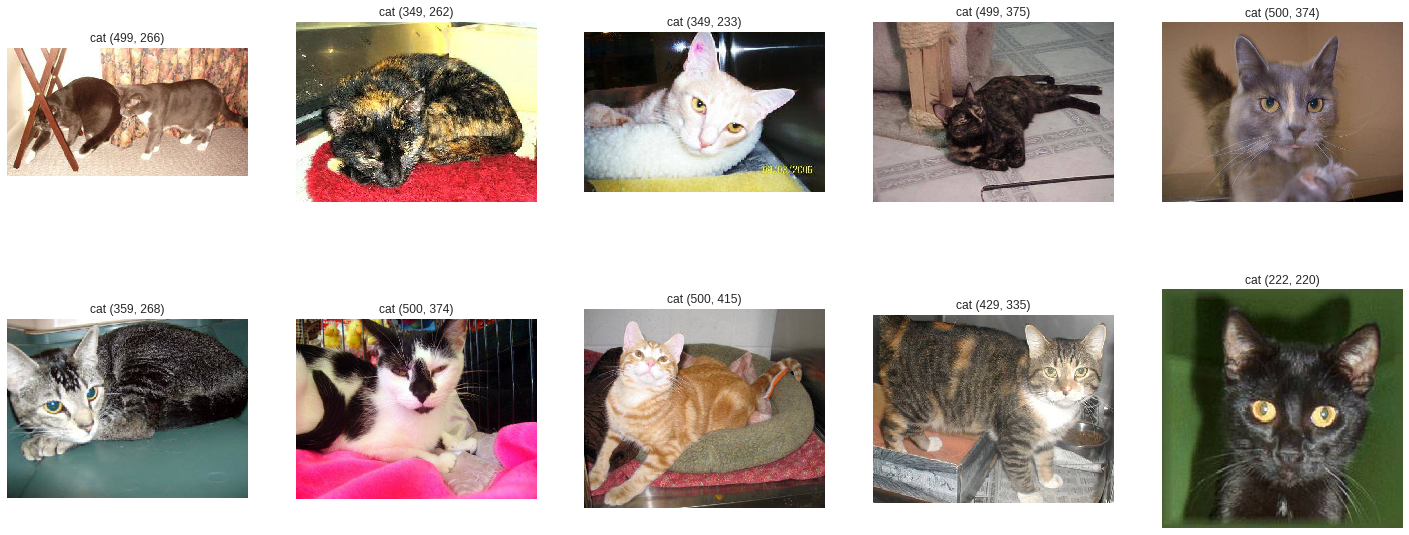

In [0]:
train_x = os.listdir(train_cats_dir)
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 10))

for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    preprocess_img(train_x[idx], ax, 'cat', train_cats_dir)
    # print out the correct label for each image

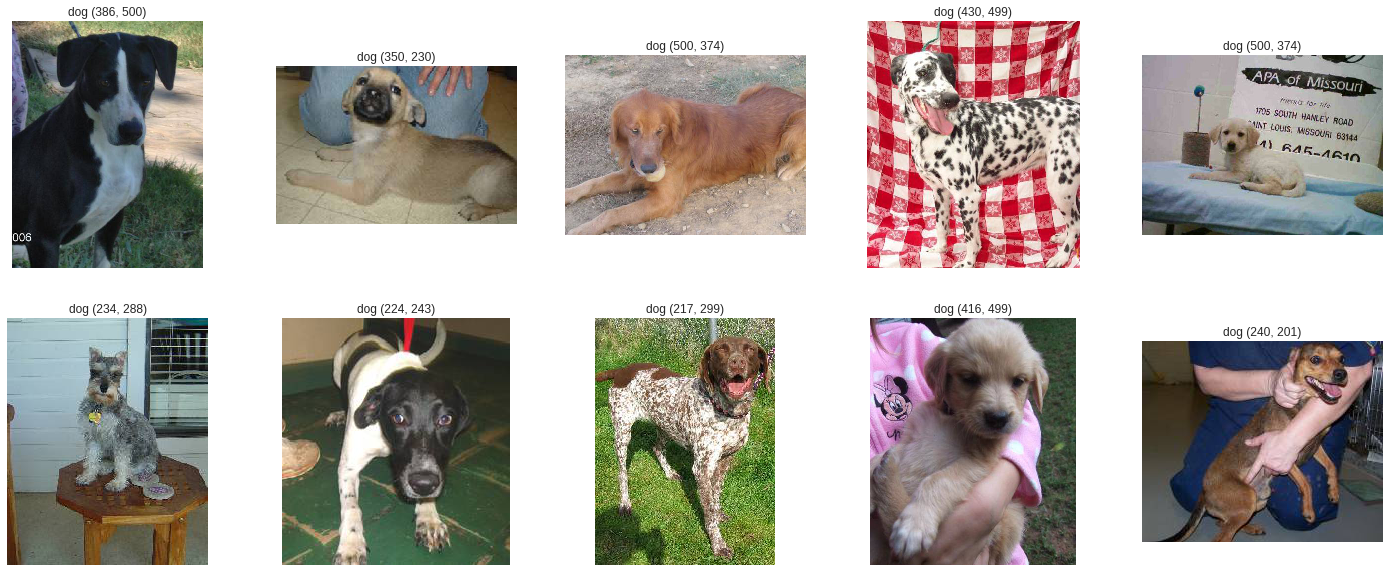

In [0]:
train_x = os.listdir(train_dogs_dir)
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 10))

for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    preprocess_img(train_x[idx], ax, 'dog', train_dogs_dir)
    # print out the correct label for each image

In [0]:
# batch size
bs = 128

# transforms
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)


path = 'data/catsvsdogs/'

In [0]:
# create databunch

data = (ImageItemList.from_folder(path)
                    .split_by_folder('train', 'val')
                    .label_from_folder()
                    .add_test_folder('test')
                    .transform(tfms, size=224)
                    .databunch(bs=bs)
                    .normalize(imagenet_stats))        

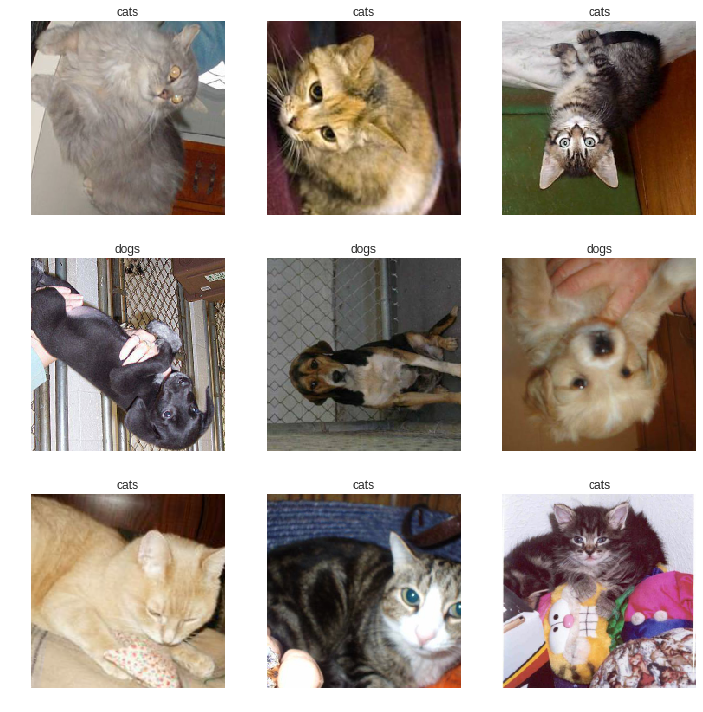

In [0]:
data.show_batch(rows=3, figsize=(10, 10))

In [0]:
print(data.classes)
len(data.classes)

['cats', 'dogs']


2

In [0]:
data.dl

<bound method DataBunch.dl of ImageDataBunch;

Train: LabelList
y: CategoryList (20000 items)
[Category dogs, Category dogs, Category dogs, Category dogs, Category dogs]...
Path: data/catsvsdogs
x: ImageItemList (20000 items)
[Image (3, 500, 386), Image (3, 230, 350), Image (3, 374, 500), Image (3, 499, 430), Image (3, 374, 500)]...
Path: data/catsvsdogs;

Valid: LabelList
y: CategoryList (5000 items)
[Category dogs, Category dogs, Category dogs, Category dogs, Category dogs]...
Path: data/catsvsdogs
x: ImageItemList (5000 items)
[Image (3, 358, 474), Image (3, 359, 480), Image (3, 335, 500), Image (3, 454, 500), Image (3, 374, 500)]...
Path: data/catsvsdogs;

Test: LabelList
y: CategoryList (12500 items)
[Category dogs, Category dogs, Category dogs, Category dogs, Category dogs]...
Path: data/catsvsdogs
x: ImageItemList (12500 items)
[Image (3, 374, 500), Image (3, 499, 337), Image (3, 364, 399), Image (3, 278, 280), Image (3, 403, 399)]...
Path: data/catsvsdogs>

In [0]:
learn = create_cnn(data, models.resnet34, metrics=[error_rate, accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


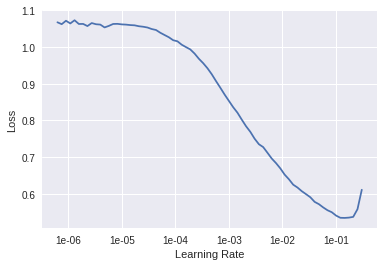

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-2
learn.fit_one_cycle(3, slice(lr))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


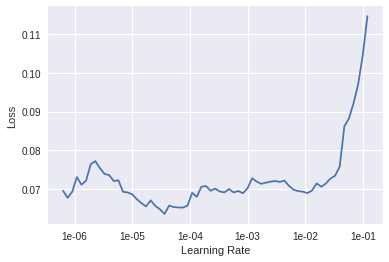

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.unfreeze()

learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

In [0]:
learn.save('224')

In [0]:
bs = 128
#create databunch with new size of 352
new_data = (ImageItemList.from_folder(path)
                    .split_by_folder('train', 'val')
                    .label_from_folder()
                    .add_test_folder('test')
                    .transform(tfms, size=352)
                    .databunch(bs=bs)
                    .normalize(imagenet_stats)) 
learn.data = new_data

In [0]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-5))

In [0]:
learn.save('352')

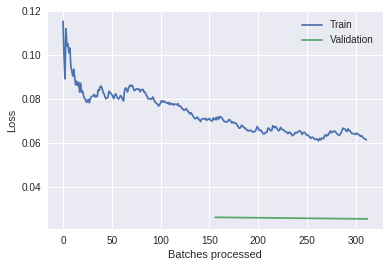

In [0]:
learn.recorder.plot_losses()

# Results

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

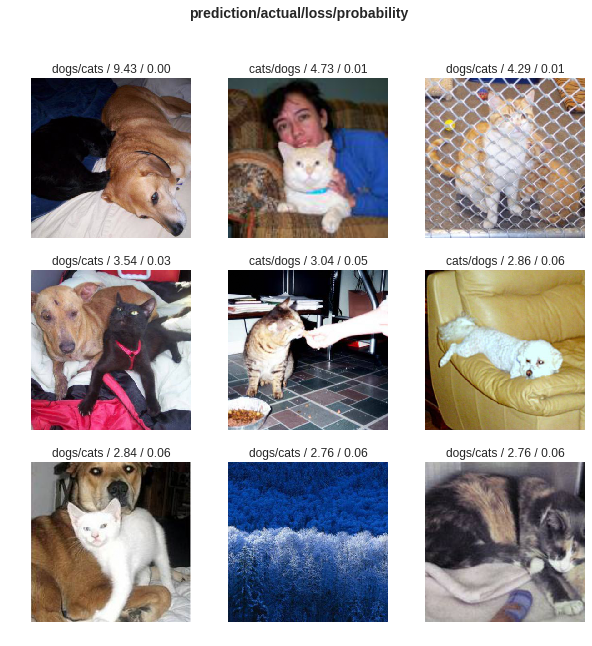

In [0]:

interp.plot_top_losses(9, figsize=(10, 10))

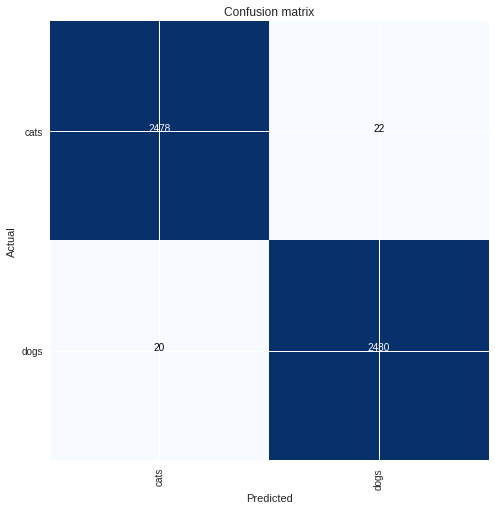

In [0]:
interp.plot_confusion_matrix(figsize=(7, 7))

In [0]:
interp.most_confused(min_val=2)

[('cats', 'dogs', 22), ('dogs', 'cats', 20)]

In [0]:
# from google.colab import files
# files.download('data/catsvsdogs/models/352.pth')

In [0]:
# from google.colab import files
# files.download('data/catsvsdogs/models/224.pth')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 40048, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil